In [3]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import numpy as np
import pandas as pd
import torch
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
df_ratings = pd.read_csv('/home/eduardoferreira/PycharmProjects/Rec_Sys/dataset/ml-latest-small/ratings.csv', sep=',')
df_movies = pd.read_csv('/home/eduardoferreira/PycharmProjects/Rec_Sys/dataset/ml-latest-small//movies.csv')

In [5]:
df_user_item = pd.merge(df_ratings, df_movies, on='movieId', how='inner')

In [6]:
d = defaultdict(LabelEncoder)
cols_cat = ['userId', 'movieId']
for c in cols_cat:
    d[c].fit(df_user_item[c].unique())
    df_user_item[c] = d[c].transform(df_user_item[c])

In [7]:
df_train = df_user_item.groupby('userId').head(-5).reset_index(drop=True)
df_val = df_user_item.groupby('userId').tail(5).reset_index(drop=True)

In [8]:
matrix = df_user_item[['userId', 'movieId', 'rating']]
X = list(zip(matrix.userId.values, matrix.movieId.values))
y = matrix.rating.values
data_t = torch.tensor(X)
labels = torch.tensor(y)
# labels = labels[:, None]

In [25]:
batch_size = 64

# split the data
train_data, test_data, train_labels, test_labels = train_test_split(data_t, labels, test_size=.1)

#convert to a pytorch 
train_dataDataset = TensorDataset(train_data, train_labels)
test_dataDataset = TensorDataset(test_data, test_labels)

# train and test dataloaders
train_loader = DataLoader(train_dataDataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataDataset, batch_size=test_dataDataset.tensors[0].shape[0])

In [11]:
train_labels.shape

torch.Size([90752])

In [16]:
class MF(nn.Module):

    def __init__(self, num_users, num_items, emb_dim, init):
        super().__init__()
        self.user_emb = nn.Embedding(num_embeddings=num_users, embedding_dim=emb_dim)
        self.item_emb = nn.Embedding(num_embeddings=num_items, embedding_dim=emb_dim)

        self.fc1 = nn.Linear(emb_dim, emb_dim * 4)
        self.fc2 = nn.Linear(emb_dim * 4, emb_dim * 2)
        self.fc3 = nn.Linear(emb_dim * 2, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        # add bias
        self.user_bias = nn.Parameter(torch.zeros(num_users))
        self.item_bias = nn.Parameter(torch.zeros(num_items))
        self.offset = nn.Parameter(torch.zeros(1))

        if init:
            self.user_emb.weight.data.uniform_(0., 0.5)
            self.item_emb.weight.data.uniform_(0., 0.5)

    def forward(self, user, item):
        user_emb = self.user_emb(user)
        item_emb = self.item_emb(item)
        element_product = (user_emb * item_emb).sum(1)

        # Reshape element_product to match the input size of self.fc1
        element_product = element_product.unsqueeze(1)  # Add an extra dimension
        element_product = element_product.expand(-1,self.fc1.in_features)  # Expand along the second dimension to match fc1 input size

        x = self.relu(self.fc1(element_product))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))

        user_b = self.user_bias[user]
        item_b = self.item_bias[item]
        # element_product += user_b + item_b + self.offset

        return x.squeeze() + user_b + item_b + self.offset


n_users = len(df_user_item.userId.unique())
n_items = len(df_user_item.movieId.unique())
mf_model = MF(n_users, n_items, emb_dim=32, init=True)
mf_model.to(device)
print(mf_model)

MF(
  (user_emb): Embedding(610, 32)
  (item_emb): Embedding(9724, 32)
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [32]:
# train the model
def train_model(num_epochs):
    loss_fun = nn.MSELoss()
    optimizer = optim.Adam(mf_model.parameters(), lr=.01)
    # initialize accuracies as empties
    train_losses = []
    val_losses = []

    # loop over epochs
    for epoch in range(num_epochs):

        # activate training mode
        mf_model.train()

        # loop over training data batches
        batch_loss = []
        for X, y in train_loader:
            # forward pass and loss
            user, item = X[:, 0], X[:, 1]
            y_rating = y.to(device, dtype=torch.float)
            y_hat = mf_model(user, item)
            loss = loss_fun(y_hat, y_rating)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss.append(loss.item())

        # append the batch loss 
        train_losses.append(np.mean(loss.item()))
        print(f'epoch {epoch + 1} loss batch: {np.mean(batch_loss)}')
        # activate testing mode
        mf_model.eval()

        # extract X,y from test dataloadermore reliable than gradient descent algorithms and their variants, and it reaches convergence at a higher speed.
        X, y = next(iter(test_loader))
        user_val, item_val = X[:, 0], X[:, 1]
        with torch.no_grad():
            y_hat = mf_model(user_val, item_val)
            loss = loss_fun(y_hat, y)
        val_losses.append(loss)

    return train_losses, val_losses


In [33]:
train_losses, val_losses = train_model(num_epochs=50)

epoch 1 loss batch: 0.6728309083766763
epoch 2 loss batch: 0.6727746597928624
epoch 3 loss batch: 0.6716653652520711
epoch 4 loss batch: 0.6717485474010112
epoch 5 loss batch: 0.6710282233143054
epoch 6 loss batch: 0.6710399628021821
epoch 7 loss batch: 0.671176732784434
epoch 8 loss batch: 0.671170912735553
epoch 9 loss batch: 0.6713455743110398
epoch 10 loss batch: 0.6709950043595224
epoch 11 loss batch: 0.6707278635715396
epoch 12 loss batch: 0.6710133705345969
epoch 13 loss batch: 0.6711502281163408
epoch 14 loss batch: 0.6712276395016228
epoch 15 loss batch: 0.6706276588530735
epoch 16 loss batch: 0.6711820957943145
epoch 17 loss batch: 0.6708902055016693
epoch 18 loss batch: 0.6711085352137663
epoch 19 loss batch: 0.6708293412358872
epoch 20 loss batch: 0.6711000665412803
epoch 21 loss batch: 0.671095932215158
epoch 22 loss batch: 0.6709081819556832
epoch 23 loss batch: 0.6711398279675308
epoch 24 loss batch: 0.6710814969201686
epoch 25 loss batch: 0.67158181427312
epoch 26 loss 

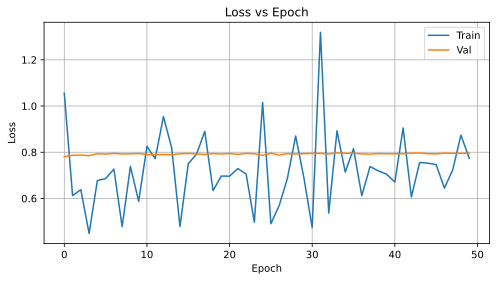

In [34]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend();


In [1]:
user_emb_min_w = mf_model.user_emb.weight.min().item()
user_emb_max_w = mf_model.user_emb.weight.max().item()
item_emb_min_w = mf_model.item_emb.weight.min().item()
item_emb_max_w = mf_model.item_emb.weight.max().item()

print(f'Emb user min/max w: {user_emb_min_w:0.3f} / {user_emb_max_w:0.3f}')
print(f'Emb item min/max w: {item_emb_min_w:0.3f} / {item_emb_max_w:0.3f}')
print(f'Preds min/max: {y_ratings.min().item():0.2f} / {y_hat.max().item():0.2f}')
print(f'Rating min/max: {yRatings.min().item():0.2f} / {yRatings.max().item():0.2f}')
print(preds.detach().cpu().numpy()[:6])
print(y_ratings.detach().cpu().numpy()[:6])

NameError: name 'mf_model' is not defined